In [1]:
%load_ext autoreload
%autoreload 2

### Run environment setup
import os
from os.path import join
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
### Import general utilities for notebook
from lib.BBData import character_dict
from lib.BBDataLoad import load_char_df
from lib.metrics.bertopic_classifier import BERTopic_classifier

In [3]:
characters = list(character_dict.keys())
characters_noDefault = list(character_dict.keys())
characters_noDefault.remove('Default')
base_folder = os.getcwd()
data_folder = join(base_folder, 'Data', 'Characters')
model_folder = join(base_folder, 'models')
embedder_path = join(os.getcwd(), 'models', 'distilbert_embedder')
bertopic_path = join(os.getcwd(), 'models', 'bertopic_classifier', 'n_sentences7')
out_folder = os.getcwd().join('tmp')
figsize = (8, 8)

F_TRAIN_DistilBERT = False

# BERTopic
It is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

In [4]:
character='Barney'
df = load_char_df(character, base_folder)
docs =  df['train']['response'] + df['test']['response'] + df['val']['response']
print(len(docs))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-256bbbeaf460349a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

5194


By default, the main steps for topic modeling with `BERTopic` are `sentence-transformers`, `UMAP`, `HDBSCAN`, and `c-TF-IDF` run in sequence. However, it assumes some independence between these steps which makes `BERTopic` quite modular. In other words, `BERTopic` not only allows us to build our own topic model but to explore several topic modeling techniques on top of our customized topic mode.

In [5]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer_model = CountVectorizer(stop_words="english")
# define BERTopic model
topic_model= BERTopic(ctfidf_model=ctfidf_model,
                      vectorizer_model=vectorizer_model, 
                      verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

2023-04-19 16:06:17,018 - BERTopic - Transformed documents to Embeddings
2023-04-19 16:06:31,880 - BERTopic - Reduced dimensionality
2023-04-19 16:06:32,034 - BERTopic - Clustered reduced embeddings


In [6]:
topic_model.visualize_topics(title='<b>'+character+' Script lines<b>')

In [7]:
topic_model.visualize_documents(docs)

## Supervised Topic Modeling

Although topic modeling is typically done by discovering topics in an unsupervised manner, there might be times when you already have a bunch of clusters or classes from which you want to model the topics.

Instead of using BERTopic to discover previously unknown topics, we are now going to manually pass them to BERTopic and try to learn the relationship between those topics and the input documents.

In [8]:
F_PRETRAINED = False
topic_model = BERTopic_classifier(join(bertopic_path, 'bertopic_classifier'), from_pretrained=F_PRETRAINED,
                                  use_cuda=True)

In [11]:
# add also default
topic_model.set_characters(characters)

F_GET_VALIDATION = False
X_train, y_train, X_val, y_val, X_test, y_test = topic_model.get_data(
    source_path = data_folder,
    val = False,
    verbose = False,
    n_sentences=7,
    override=True
)
len(X_train), X_val, len(X_test)

(8168, None, 1416)

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

2023-04-19 16:13:17,735 - BERTopic - Transformed documents to Embeddings
2023-04-19 16:13:17,736 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-04-19 16:13:17,736 - BERTopic - Reduced dimensionality
2023-04-19 16:13:21,096 - BERTopic - Clustered reduced embeddings


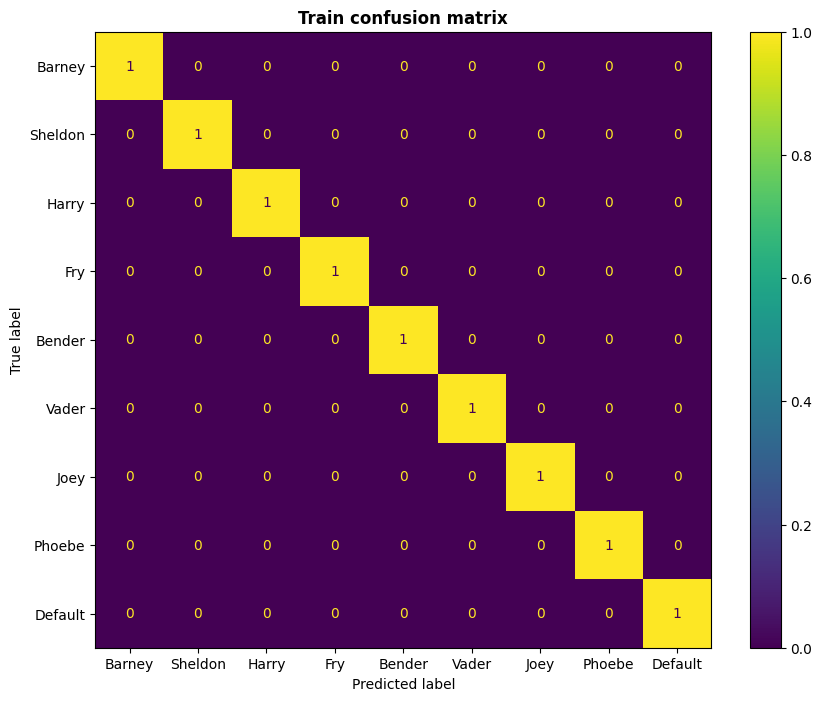

In [12]:
topic_model.train((X_train, y_train))

In [13]:
topic_model.plot_documents()

In [14]:
_, inv_mapping = topic_model.get_mapping()
print(f'[class    || Topic]')
for clss, topic in zip(inv_mapping.keys(), inv_mapping.values()):
    print(f' {characters[clss]:8} ->  {topic:2}')

[class    || Topic]
 Vader    ->   0
 Sheldon  ->   1
 Fry      ->   2
 Harry    ->   3
 Bender   ->   4
 Default  ->   5
 Phoebe   ->   6
 Joey     ->   7
 Barney   ->   8


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

2023-04-19 16:13:47,725 - BERTopic - Reduced dimensionality
2023-04-19 16:13:47,727 - BERTopic - Predicted clusters


F1 score: 0.7555078730322995


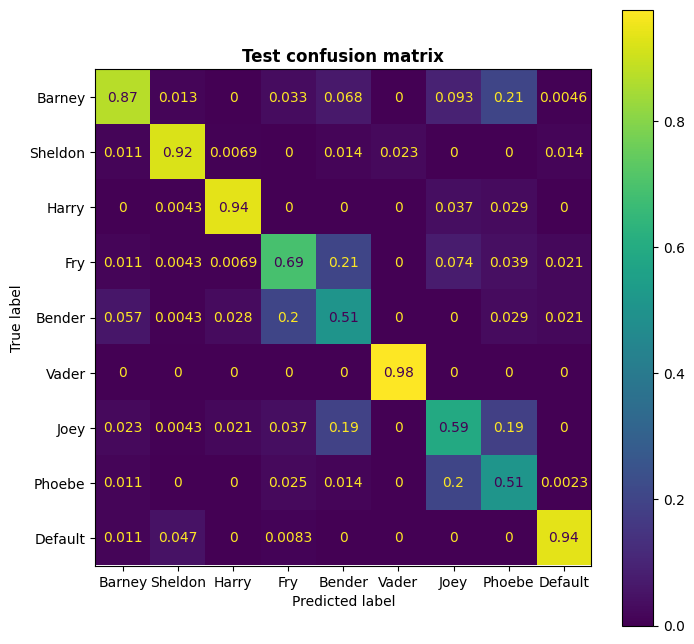

In [15]:
y_test_pred = topic_model.predict((X_test, y_test))
print('F1 score:', f1_score(y_test, y_test_pred, average='macro'))

In [16]:
topic_model.plot_barchart()

Having generated topic embeddings, through both `c-TF-IDF` and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [17]:
topic_model.plot_similmatrix()

## Attempt with chatbot predictions

In [18]:
X_chatbot_test, y_chatbot_test = topic_model.get_chatbot_data(n_sentences=7)
len(X_chatbot_test), len(y_chatbot_test)

Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file


100%|██████████| 751/751 [00:00<00:00, 14542.71it/s]


(7726, 7726)

Batches:   0%|          | 0/242 [00:00<?, ?it/s]

2023-04-19 16:14:09,923 - BERTopic - Reduced dimensionality
2023-04-19 16:14:09,929 - BERTopic - Predicted clusters


F1 score: 0.32928635183166977


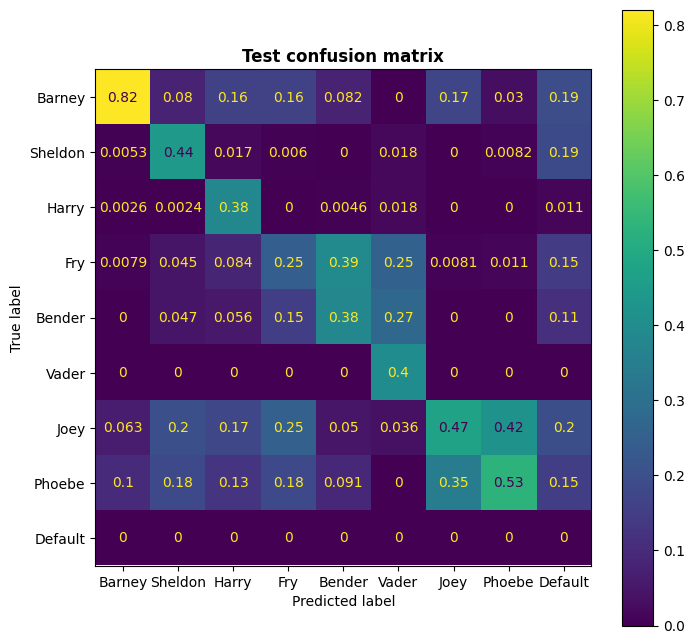

In [19]:
y_chatbot_test_pred = topic_model.predict((X_chatbot_test, y_chatbot_test))
print('F1 score:', f1_score(y_chatbot_test, y_chatbot_test_pred, average='macro'))